# 1. Zadatak

U prvom zadatku je traženo da se napravi green screen od kraljičine haljine. Moja ideja za izradu ovog zadatka je da iz rgb kolor sistema pređem u hsv kako bih dobio informaciju o boji i saturaciji i na taj način napravio masku. Nakon Toga kako bih zadržao informaciju o osvetljenosti i kako bih lakše mogao da prenesem boje čija je saturacija jako mala (crna), prebacio sam u yuv kolor sistem. Na taj način manipulacijom nad komponentama u i v sam ubacio željenu sliku na mestu maske.

In [1]:
from pylab import *
import matplotlib.pyplot as plt
import skimage
from skimage import color
from skimage import exposure
from skimage import filters
from skimage import io
from pylab import *
from pylab import *
import imageio
from scipy import ndimage
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np

Ulazna slika izgleda ovako:

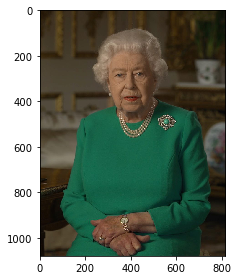

In [2]:
imgQueen = imread('queen_dress.jpg')

io.imshow(imgQueen)

Kada prebacim sliku iz RGB kolor sistema u YUV ovako izgledaju svaka od komponenti slike u HSV formatu.

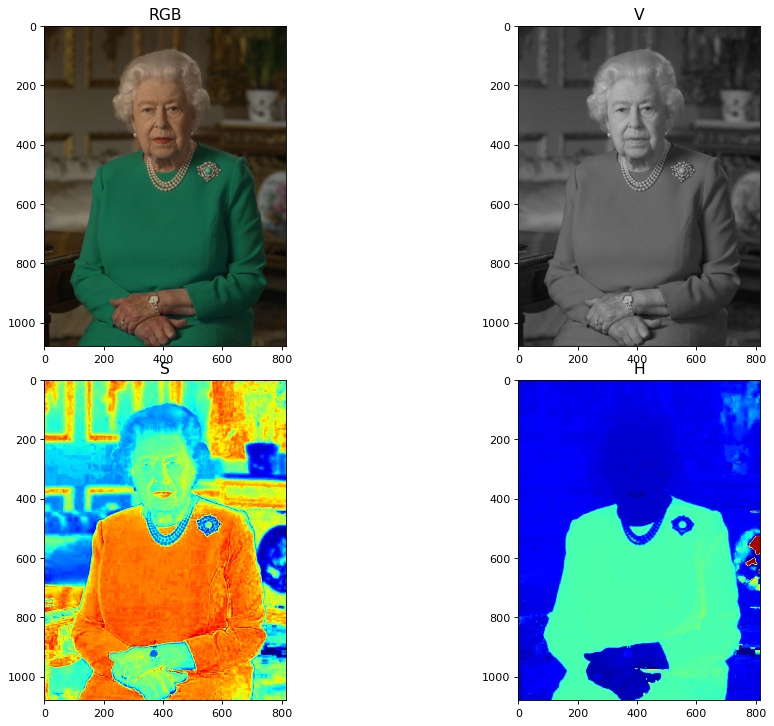

In [4]:
imgQueenHSV = color.rgb2hsv(imgQueen)
fig, ax = plt.subplots(2, 2, figsize=(12,9), dpi=80);
tight_layout();
ax[0,0].imshow(imgQueen); ax[0,0].set_title('RGB', fontsize=14);
ax[0,1].imshow(imgQueenHSV[:,:,2], vmin=0, vmax=1, cmap='gray'); ax[0,1].set_title('V', fontsize=14);
ax[1,0].imshow(imgQueenHSV[:,:,1], vmin=0, vmax=1, cmap='jet'); ax[1,0].set_title('S', fontsize=14);
ax[1,1].imshow(imgQueenHSV[:,:,0], vmin=0, vmax=1, cmap='jet'); ax[1,1].set_title('H', fontsize=14);

Za obradu slike, a i snimka koristio sam sledeću funkciju. Drugu sliku sam ubacivao u YUV formatu, jer mi je taj kolor sistem potreban za dodavanje slike. Unosim taj format slike kako bih uštedeo vreme i ne radim svaki put prebacivanje u YUV kolor sistem za svaki frame (kasnije kada dođe do obrade snimka).

In [6]:
def dressQueen(rgbQueen: np.array, yuvImg: np.array) -> np.array:
    # prebacivanje u HSV i YUV kolor sistem
    imgQueenHSV = color.rgb2hsv(rgbQueen)
    imgQueenYUV = color.rgb2yuv(rgbQueen)
    # skaliranje Y komponente kako bih mogao da skaliram Y komponentu druge slike
    yComp = imgQueenYUV[:,:,0]/np.max(imgQueenYUV[:,:,0])
    size1 = rgbQueen.shape
    
    # pravljenje maske na osnovu vrednosti boje i saturacije
    mask = (imgQueenHSV[:,:,0]>0.2) & (imgQueenHSV[:,:,0]<0.5) & (imgQueenHSV[:,:,1]>=0.5)
    
    # množim sa vrednostima saturacije kako bih dobio što manje vrednosti za one delove slike koji su se "provukli"
    mask = mask*imgQueenHSV[:,:,1]
    # filtriranje gausovim filtrom kako bih smanjio komponente van haljine
    mask_gauss = filters.gaussian(mask, sigma=10, truncate=2)
    
    # pravljenje nvrednosti koje treba da se ubace umesto haljine
    newY = imgYUV[0:size1[0],0:size1[1],0]
    newU = imgYUV[0:size1[0],0:size1[1],1]
    newV = imgYUV[0:size1[0],0:size1[1],2]
    
    # konacno pravljenje maske za haljinu
    mask1 = mask_gauss>0.6
    
    # za sve frame-ove koji imaju manje od 10000 piksela umesto kojih treba staviti drugu sliku treba da se odbace,
    # jer je to premali broj piksela i to su frame-ovi gde se kraljica uopšte ne nalazi.
    if np.sum(mask1)<10000:
        return rgbQueen
    
    # stavljanje druge slike umesto haljine
    imgQueenYUV[mask1,0] = newY[mask1]*yComp[mask1]
    imgQueenYUV[mask1,1] = newU[mask1]
    imgQueenYUV[mask1,2] = newV[mask1]
    
    # vracanje u RGB kolor sistem
    imgQueenOutput = color.yuv2rgb(imgQueenYUV)
    
    return imgQueenOutput

Testiranje funkcije nad slikom.

# 3. zadatak

U ovom zadatku je potrebno uraditi CLAHE obradu slike. CLAHE zahteva nekoliko koraka, a to su: podela slike na blokove, pravljenje histograma (funkciju gustinu verovatnoće) za svaki od blokova, ograničavanje histograma, pravljenje funkcije raspodele za svaki od blokova i određivanje intenziteta svakog piksela bilinearnom interpolacijom.

Radi preglednosti koda sve ove funkcionalnosti sam podelio u funkcije i spojio ih u jednu funkciju dosCLAHE. Funkcionalnosti određenih funkcija ću testirati na celoj slici, iako je slika deljena u blokove.

In [1]:
from pylab import *
import numpy as np
from skimage import color
from skimage import io
import matplotlib.pyplot as plt
import math
from skimage import *
import os

Prvo dodajem sliku koju treba obraditi. Ovu sliku ću pretvoriti i u gray scale sliku.

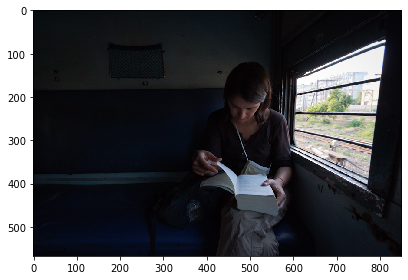

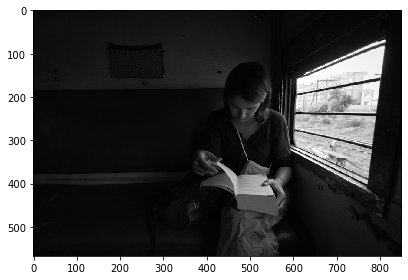

In [6]:
imgIn = imread('train.jpg')
plt.figure()
io.imshow(imgIn)
img1 = color.rgb2yuv(imgIn)
imgInGray = img_as_ubyte(img1[:,:,0])
plt.figure()
io.imshow(imgInGray)

Napravio sam 2 funkcije za histogram u zavisnosti od toga da li je u pitanju rgb ili gray scale slika. Narvno to je moglo da se odradi samo sa jednom funkcijom koja određuje samo za gray scale pa da pozovemo 3 puta kada određujemo za rgb, ali mi se ovo činilo kao bolje rešenje.

In [7]:
def makeHist2D(imgIn: np.array) -> np.array:
    """

    Parameters
    ----------
    imgIn : np.array
        Input image- gray scale.

    Returns
    -------
    np.array
        Histogram of the gray scale image.

    """
    numHist = np.zeros(256, dtype = float)
    for i in range(0, 256):
        numHist[i] = np.sum(imgIn == i)
    return numHist/imgIn.size

def makeHist3D(imgIn: np.array) -> np.array:
    """

    Parameters
    ----------
    imgIn : np.array
        Input image- rgb.

    Returns
    -------
    np.array
        Return 3 histograms for each component of rgb image.

    """
    numHist = np.zeros([256,3], dtype = float)
    for i in range(0, 256):
        numHist[i,0]=np.sum(imgIn[:,:,0]==i)
        numHist[i,1]=np.sum(imgIn[:,:,1]==i)
        numHist[i,2]=np.sum(imgIn[:,:,2]==i)
    return numHist/imgIn[:,:,0].size

Rezultati ove dve funkcije predstavljam plotom, jer se ne vidi lepo ako odradim stem.

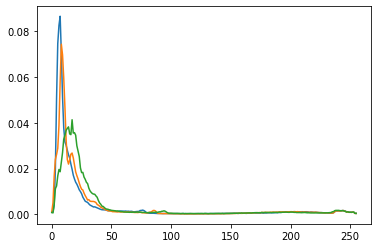

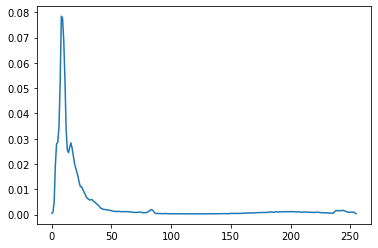

In [8]:
hist=makeHist3D(imgIn)
histGray = makeHist2D(imgInGray)
plt.figure()
plt.plot(hist)
plt.figure()
plt.plot(histGray)

Napisao sam jednu funkciju koja limitira histogram i koja računa funkciju raspodele za dati histogram.

In [ ]:
def makeT(histogram: np.array, limit: float) -> np.array:
    """


    Parameters
    ----------
    histogram : np.array
        Values of histogram.
    limit : float
        Limit for histogram.

    Returns
    -------
    T : np.array
        Returns the distribution function and limits the histogram.

    """
    # limiting the histogram
    T1 = sum(histogram[histogram > limit])-sum(histogram > limit)*limit
    histogram[histogram > limit] = limit
    histogram = histogram + T1/256
    # calculating the distribution function
    T = np.cumsum(histogram)
    # scaling the distribution function
    T = T*255
    return np.floor(T)